# Convolutional neural network for classifying Root data fits.


Here, we define, train, and save new convolutional models as well as some 
simple model evaluation. We define hyper-parameters, number of layers, and 
training and testing datasets. 

Here, at the final layer, the network takes into account chi squared per degree of freedom.

## Load necessary packages

In [2]:
# Load some packages

# Keras packages for network
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Conv2D, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD
# For saving model
from keras.models import model_from_json
from keras.layers import concatenate, Lambda

# Some items for plotting and drawing
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt

# Need numpy
import numpy as np
import nn_utils as utils

%matplotlib inline

Using TensorFlow backend.


## Load root fit data from file

In [3]:
# Define image file path
im_path="/media/data/Projects/fit_pmt/images/png_fit_nn/"

# Load dataset
x, y, params = utils.load_dataset_all(m=500, im_dir="train", log=False, im_path=im_path)
x_log, _, _ = utils.load_dataset_all(m=500, im_dir="train", log=True, im_path=im_path)

# Load dev set
x_dev, y_dev, params_dev = utils.load_dataset_all(im_dir="dev", log=False, im_path=im_path)
x_dev_log, _, _ = utils.load_dataset_all(im_dir="dev", log=True, im_path=im_path)
m_dev = x_dev.shape[0]

# Grab dimensions of picture
(m, h, w, c) = x.shape
m_dev = x_dev.shape[0]
input_shape = h, w, c
num_params = params.shape[1]

# Print dimensions
print("(m, height, width, channels): (" + str(m) + ", " + str(h) + ", " + str(w) + ", " + str(c) + ")")
print("m_dev: " + str(m_dev))
print("y: " + str(y.shape))
print("params: " + str(params.shape))


(m, height, width, channels): (500, 236, 348, 3)
m_dev: 129
y: (500, 1)
params: (500, 54)


### Print an image

label: good
label: [1]
params: [ 0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  2.000000e+01
  5.000000e-02  6.144692e+02  2.252700e+00  1.000000e-02  2.560000e+00
  4.000000e+00  2.252700e+00  5.000000e-01  5.000000e-01  1.000000e-03
 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00
 -1.000000e+00  0.000000e+00  0.000000e+00  5.000000e-01 -1.000000e+00
 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00
  1.000000e+00  1.000000e+00  6.400000e-03  6.130692e+02  1.706800e+00
  5.000000e-02  5.411800e+00  1.132900e+00  1.556800e+00  1.765000e-01
  8.235000e-01  2.000000e-04  1.620000e-02  1.270000e-02  1.000000e-03
  8.910000e-02  1.870000e-02  1.070000e-02  2.800000e-03  3.000000e-03
  6.254000e+00  1.768000e-01  7.300000e-03  4.130900e+00]


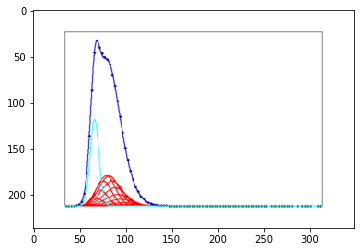

In [4]:
# Print an image
index = 420
this_image = x[index]
if y[index] == 1:
    print("label: good")
else:
    print("label: bad")
print("label: " + str(y[index]))
print("params: " + str(params[index]))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

# Define and Train multi-layer ConvNet with 2 fully connected layers plus output layer

For the convolutional layer, we will scan over our images with a certain stride and a certain kernal size. 
Each individual scan represents a single neuron in the next layer. Since each scan connects to kernal size squared
neurons below it, convolutions reduce the number of degrees of freedom. Hopefully, through learning the right filters,
we can preserve the important information as we reduce it in size.

Once the image has gone through the convolutional layers (and therefore has been reduced to its features vector), we
can send the resulting vector into some old-fashioned fully-connected layers, and finally into a logistic regression unit.

## Define hyperparameters

In [5]:
# Initialize
filters = []
kernels = []
strides = []
pools = []
dropouts = []

# Conv1
filters.append(32)
kernels.append(5)
strides.append(2)
pools.append(1)
dropouts.append(0.2)

# Conv2
filters.append(32)
kernels.append(7)
strides.append(2)
pools.append(1)
dropouts.append(0.2)

# Conv3
filters.append(128)
kernels.append(9)
strides.append(2)
pools.append(2)
dropouts.append(0.2)

# Define dense (fully-connected) layer sizes
fc1 = 40
fc2 = 10

## Define keras layers (model)

Our model contains two convolutional models in parallel, each with multiple layers. We run two in parallel to utilize log scale images AND linear scale (different information present). 

After we convolve the images, we flatten them and concatenate them. We also concatenate to them a list of inputs and outputs to and from the root fit algorithm such as parameter initial condition and bounds, output parameters plus errors, and chi-squared per degree of freedom.

After concatenating these three sources of information together, we send them through some fully-connected layers to allow learning from all three sources simultaneously.

Dropout is used here for regularization.
Pooling is used here to speed up computation.
Batch normalization is used to aid in learning at deeper layers.

In [6]:
# Define input layer (RGB image matrix)
X = Input(shape=input_shape, name='Input')

# Define additional input info
X_log = Input(shape=input_shape, name='InputLog')

# Define additional input info
Params = Input(shape=(num_params,), name='Params')

# Initialize activation as input
a = X
a_log = X_log
# Loop through all convolutional layers
for i in range(len(filters)):
    # Perform convolution
    a = Conv2D(filters=filters[i], kernel_size=(kernels[i], kernels[i]), strides=(strides[i], strides[i]), name=('conv' + str(i)))(a)
    a_log = Conv2D(filters=filters[i], kernel_size=(kernels[i], kernels[i]), strides=(strides[i], strides[i]), name=('conv_log' + str(i)))(a_log)
    # Normalize
    a = BatchNormalization(axis=3, name=('bn' + str(i)))(a)
    a_log = BatchNormalization(axis=3, name=('bn_log' + str(i)))(a_log)
    # Activate
    a = Activation('elu', name=('a' + str(i)))(a)
    a_log = Activation('elu', name=('a_log' + str(i)))(a_log)
    # Max-pool
    a = MaxPooling2D((pools[i], pools[i]), name=('max_pool' + str(i)))(a)
    a_log = MaxPooling2D((pools[i], pools[i]), name=('max_pool_log' + str(i)))(a_log)
    # Dropout
    a = Dropout(rate=dropouts[i])(a)
    a_log = Dropout(rate=dropouts[i])(a_log)

# Flatten output of convNet
a = Flatten()(a)
a_log = Flatten()(a_log)
# Define first fully connected layer
a = Dense(units=fc1, activation='elu', name='fc0')(a)
a_log = Dense(units=fc1, activation='elu', name='fc0_log')(a_log)
# Use some dropout here for regularization
a = Dropout(rate=0.2)(a)
a_log = Dropout(rate=0.2)(a_log)

# Combine log and non log outputsdef concat_vectors(input):
def concat_vectors(input):
    a = input[0]
    b = input[1]
    return concatenate([a,b], axis=1)
a_both = Lambda(concat_vectors, name='concat_layer')([a, a_log])

# Activate parameters
a_params = Activation('tanh', name='param_act')(Params)

# Concatenate parameters to activations
a_final = Lambda(concat_vectors, name='concat_vectors')([a_both, a_params])

# Define second fully connected layer
a_final = Dense(units=fc2, activation='relu', name='fc1')(a_final)                                 
a_final = Dropout(rate=0.2)(a_both)
a_final = Dense(units=fc2, activation='relu', name='fc2')(a_final)
# Define output layer 
a_final = Dense(units=1, activation='sigmoid', name='sigmoid')(a_final)

# Make the model
model = Model(inputs=[X, X_log, Params], outputs=a_final)

##### Define optimizer, loss, and metrics. Compile model.

In [7]:
# Define optimizer
#opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001)
opt = SGD(lr=1.0, decay=1e-6, momentum=0.9, nesterov=True)
# Define loss
loss = 'mean_squared_error'
# Define metrics to use
metrics=['acc']
# Compile model
model.compile(loss=loss, optimizer='sgd', metrics=metrics)
# Print summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 236, 348, 3)  0                                            
__________________________________________________________________________________________________
InputLog (InputLayer)           (None, 236, 348, 3)  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 116, 172, 32) 2432        Input[0][0]                      
__________________________________________________________________________________________________
conv_log0 (Conv2D)              (None, 116, 172, 32) 2432        InputLog[0][0]                   
__________________________________________________________________________________________________
bn0 (Batch

## Fit the model to the data (train)

In [12]:
# Now, fit the model to the data
histories = []
for ii in range(2):
    history = model.fit([x, x_log, params], y, validation_data=([x_dev, x_dev_log, params_dev], y_dev), epochs=50, batch_size=64)
    histories.append(history)

Train on 500 samples, validate on 129 samples
Epoch 1/50
500/500 [==============================] - 5s 10ms/step - loss: 0.0447 - acc: 0.9440 - val_loss: 0.2482 - val_acc: 0.6589
Epoch 2/50
500/500 [==============================] - 5s 10ms/step - loss: 0.0477 - acc: 0.9480 - val_loss: 0.2401 - val_acc: 0.6977
Epoch 3/50
500/500 [==============================] - 5s 10ms/step - loss: 0.0389 - acc: 0.9500 - val_loss: 0.2304 - val_acc: 0.6744
Epoch 4/50
500/500 [==============================] - 5s 10ms/step - loss: 0.0413 - acc: 0.9460 - val_loss: 0.2408 - val_acc: 0.6822
Epoch 5/50
500/500 [==============================] - 5s 10ms/step - loss: 0.0319 - acc: 0.9560 - val_loss: 0.2640 - val_acc: 0.6512
Epoch 6/50
500/500 [==============================] - 5s 9ms/step - loss: 0.0389 - acc: 0.9520 - val_loss: 0.2175 - val_acc: 0.7209
Epoch 7/50
500/500 [==============================] - 5s 10ms/step - loss: 0.0339 - acc: 0.9640 - val_loss: 0.2566 - val_acc: 0.6667
Epoch 8/50
500/500 [====

Epoch 12/50
500/500 [==============================] - 5s 10ms/step - loss: 0.0199 - acc: 0.9760 - val_loss: 0.2550 - val_acc: 0.6434
Epoch 13/50
500/500 [==============================] - 5s 9ms/step - loss: 0.0204 - acc: 0.9740 - val_loss: 0.2102 - val_acc: 0.7364
Epoch 14/50
500/500 [==============================] - 5s 10ms/step - loss: 0.0211 - acc: 0.9700 - val_loss: 0.2711 - val_acc: 0.6512
Epoch 15/50
500/500 [==============================] - 5s 10ms/step - loss: 0.0177 - acc: 0.9780 - val_loss: 0.2261 - val_acc: 0.6744
Epoch 16/50
500/500 [==============================] - 5s 10ms/step - loss: 0.0179 - acc: 0.9840 - val_loss: 0.2439 - val_acc: 0.6822
Epoch 17/50
500/500 [==============================] - 5s 9ms/step - loss: 0.0200 - acc: 0.9740 - val_loss: 0.2581 - val_acc: 0.6512
Epoch 18/50
500/500 [==============================] - 5s 9ms/step - loss: 0.0207 - acc: 0.9760 - val_loss: 0.2502 - val_acc: 0.6744
Epoch 19/50
500/500 [==============================] - 5s 9ms/ste

### Print training results

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


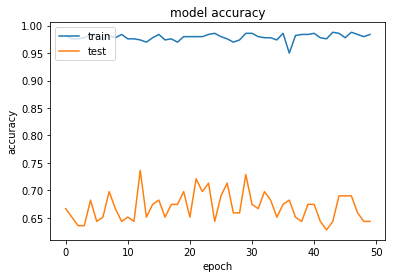

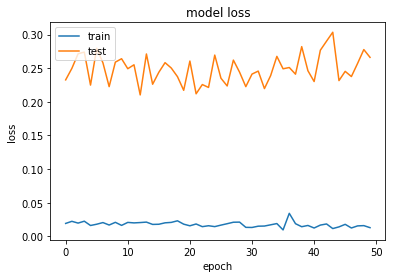

In [14]:
# List all data in history
index = 1
print(histories[index].history.keys())
# Summarize history for accuracy
plt.plot(histories[index].history['acc'])
plt.plot(histories[index].history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(histories[index].history['loss'])
plt.plot(histories[index].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Additional model evaluation

In [13]:
# Load dev set
x_dev, y_dev, params_dev = utils.load_dataset_all(im_dir="dev", log=False, im_path=im_path)
x_dev_log, _, _ = utils.load_dataset_all(im_dir="dev", log=True, im_path=im_path)
m_dev = x_dev.shape[0]

In [15]:
# Evaluate model, get metrics back
stats = model.evaluate([x_dev, x_dev_log, params_dev], y_dev)
# Calculate predictions vector from model
predictions = model.predict([x_dev, x_dev_log, params_dev])
predictions = np.floor(predictions + 0.5)

# Get vector mask for good and bad fits and right and wrong answers
good_fits = y_dev
bad_fits = 1 - good_fits
wrong_answers = np.abs(np.subtract(predictions, good_fits))
right_answers = np.subtract(1, wrong_answers)
# Calculate true positives (tp), as well as (tn) (fp) (fn)
true_positives = np.multiply(right_answers, good_fits)
true_negatives = np.multiply(right_answers, bad_fits)
false_positives = np.multiply(wrong_answers, good_fits)
false_negatives = np.multiply(wrong_answers, bad_fits)
# Calculate additional metrics
precision = np.sum(true_positives) / np.sum(true_positives + false_positives)
recall = np.sum(true_positives) / np.sum(true_positives + false_negatives)

# Print stats
print()
print("Performance on VALIDATION set")
print(".............................")
print("Loss: " + str(stats[0]))
print("Accuracy: " + str(stats[1]))
print("Precision: " + str(precision))
print("Recall: " + str(recall))

# Print list of indices of wrong answers
bad_list = []
for i in range(m_dev):
    if wrong_answers[i] == 1:
        bad_list.append(i)
print(".............................")
print("List of indices of wrong guesses:")
print(bad_list)

129/129 [==============================] - 1s 9ms/step

Performance on VALIDATION set
.............................
Loss: 0.12023067424189328
Accuracy: 0.8682170542635659
Precision: 0.8392857142857143
Recall: 0.8545454545454545
.............................
List of indices of wrong guesses:
[0, 3, 4, 6, 10, 18, 24, 35, 42, 78, 79, 83, 84, 85, 88, 92, 93]


## Look at an image

label: [1]
prediction: [0.]
(236, 348, 3)


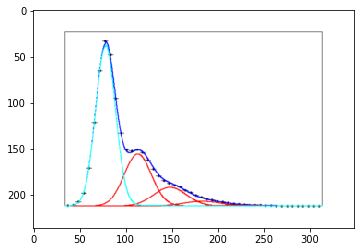

In [19]:
# Choose an index 
index = 6

# Print labels for this index
print("label: " + str(good_fits[index]))
print("prediction: " + str(predictions[index]))

# Show image
this_image = x[index]
print(str(this_image.shape))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

## Load pretrained conv model

In [47]:
# load json and create model
json_file = open('trained/conv_model_quickngood.json', 'r')
conv_model_json = json_file.read()
json_file.close()
model = model_from_json(conv_model_json)
# load weights into new model
model.load_weights("trained/conv_model_quickngood.h5")
print("Loaded model from disk")

Loaded model from disk


## Save convolutional model to disc

In [65]:
#plot_model(simple_model, to_file='simple_model.png')
#SVG(model_to_dot(simple_model).create(prog='dot', format='svg'))

# serialize model to JSON
model_json = model.to_json()
with open("trained/conv_model_chi_500epoch.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("trained/conv_model_chi_500epoch.h5")
print("Saved model to disk")

Saved model to disk
